In [544]:
import pandas as pd
import dash
from dash import dcc, Input, Output, html
import dash_bootstrap_components as dbc
import dash_mantine_components as dmc
from dash_bootstrap_templates import load_figure_template
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
load_figure_template('cyborg')


In [545]:
date_df = pd.read_csv('/Users/gaurav/Desktop/Codebasics Data/Supply-chain/C2 Input for participants/dim_date.csv')
customer_df = pd.read_csv('/Users/gaurav/Desktop/Codebasics Data/Supply-chain/C2 Input for participants/dim_customers.csv')
product_df = pd.read_csv('/Users/gaurav/Desktop/Codebasics Data/Supply-chain/C2 Input for participants/dim_products.csv')
target_df = pd.read_csv('/Users/gaurav/Desktop/Codebasics Data/Supply-chain/C2 Input for participants/dim_targets_orders.csv')
order_df = pd.read_csv('/Users/gaurav/Desktop/Codebasics Data/Supply-chain/C2 Input for participants/fact_order_lines.csv')
agg_df = pd.read_csv('/Users/gaurav/Desktop/Codebasics Data/Supply-chain/C2 Input for participants/fact_orders_aggregate.csv')

In [546]:
# Merging data-frames
order_df = pd.merge(order_df, customer_df, on='customer_id', how= 'inner')
order_df = pd.merge(order_df, product_df, on='product_id', how= 'inner')
order_df = pd.merge(order_df, target_df, on='customer_id', how = 'inner')

# Convert date columns to datetime format
order_df['order_placement_date'] = pd.to_datetime(order_df['order_placement_date'])
order_df['agreed_delivery_date'] = pd.to_datetime(order_df['agreed_delivery_date'])
order_df['actual_delivery_date'] = pd.to_datetime(order_df['actual_delivery_date'])


In [547]:
date_df['order_date'] = pd.to_datetime(date_df['date'], format='%d-%b-%y')
date_df['month_name'] = date_df['order_date'].apply(lambda x: x.strftime('%B'))
date_df = date_df.drop(columns = ['date', 'mmm_yy'])

In [548]:

#Creating Order-level-split
order_level_df = order_df.groupby(['order_id', 'customer_name', 'order_placement_date', 'city', 'product_name', 'category']).agg({
    'In Full': ['min', 'sum', 'size'],
    'On Time': 'min',
    'On Time In Full': 'min',
    'order_qty': 'sum',
    'delivery_qty': 'sum',
    'ontime_target%': 'mean',
    'infull_target%': 'mean',
    'otif_target%': 'mean'
}).reset_index()

#Redefining the Column names
order_level_df.columns = ['order_id', 'customer_name', 'order_date', 'city', 'product_name', 'category', 'in_full','in_full_sum', 'in_full_size', 'on_time', 'otif', 'order_qty_sum', 'delivery_qty_sum', 'ontime_target%', 'infull_target%', 'otif_target%']

#Calcuating Line Fill Rate and Volume Fill Rate
order_level_df['line_fr'] = order_level_df['in_full_sum'] / order_level_df['in_full_size'] * 100
order_level_df['volume_fr'] = order_level_df['delivery_qty_sum'] / order_level_df['order_qty_sum'] * 100

In [549]:
#Creating Date-level-split
date_level_df = order_level_df.groupby(['order_date']).agg({
    'on_time': 'sum',
    'in_full': 'sum',
    'otif': 'sum',
    'order_id': 'count',
    'in_full_sum': 'sum',
    'in_full_size': 'sum',
    'order_qty_sum': 'sum',
    'delivery_qty_sum': 'sum'
}).reset_index()

date_level_df.columns = ['order_date', 'on_time', 'in_full', 'otif', 'order_count', 'in_full_sum','in_full_size', 'order_qty_sum', 'delivery_qty_sum']

date_level_df['in_full_P'] = date_level_df['in_full'] / date_level_df['order_count'] * 100
date_level_df['on_time_P'] = date_level_df['on_time'] / date_level_df['order_count'] * 100
date_level_df['otif_P'] = date_level_df['otif'] / date_level_df['order_count'] * 100
date_level_df['line_fr'] = date_level_df['in_full_sum'] / date_level_df['in_full_size'] * 100
date_level_df['volume_fr'] = date_level_df['delivery_qty_sum'] / date_level_df['order_qty_sum'] * 100
date_level_df = pd.merge(date_level_df, date_df, on='order_date', how= 'inner')

month_df = date_level_df.groupby(['month_name']).mean().reset_index()

week_df = date_level_df.groupby(['week_no']).mean().reset_index()


In [550]:

# Creating City-level-Split
city_level_df = order_level_df.groupby(['city']).agg({
    'on_time': 'sum',
    'in_full': 'sum',
    'otif': 'sum',
    'order_id': 'count',
    'in_full_sum': 'sum',
    'in_full_size': 'sum',
    'order_qty_sum': 'sum',
    'delivery_qty_sum': 'sum',
    'ontime_target%': 'mean',
    'infull_target%': 'mean',
    'otif_target%': 'mean'
}).reset_index()

city_level_df.columns = ['city', 'on_time', 'in_full', 'otif', 'order_count', 'in_full_sum','in_full_size', 'order_qty_sum', 'delivery_qty_sum', 'ontime_target%', 'infull_target%', 'otif_target%']

city_level_df['in_full_P'] = city_level_df['in_full'] / city_level_df['order_count'] * 100
city_level_df['on_time_P'] = city_level_df['on_time'] / city_level_df['order_count'] * 100
city_level_df['otif_P'] = city_level_df['otif'] / city_level_df['order_count'] * 100
city_level_df['line_fr'] = city_level_df['in_full_sum'] / city_level_df['in_full_size'] * 100
city_level_df['volume_fr'] = city_level_df['delivery_qty_sum'] / city_level_df['order_qty_sum'] * 100

In [572]:
#creating customer-level-split
customer_level_df = order_level_df.groupby(['customer_name',]).agg({
    'in_full': 'sum',
    'in_full_sum': 'sum',
    'in_full_size': 'sum',
    'order_id': 'count',
    'on_time': 'sum',
    'otif': 'sum',
    'order_qty_sum': 'sum',
    'delivery_qty_sum': 'sum',
    'ontime_target%': 'min',
    'infull_target%': 'min',
    'otif_target%': 'min'
}).reset_index()

#Redefining the Column names
customer_level_df.columns = ['customer_id', 'in_full', 'ifsum','ifsize', 'order_count', 'on_time', 'otif', 'order_qty_sum', 'delivery_qty_sum','ontime_target%', 'infull_target%', 'otif_target%']

#Calcuating Line Fill Rate and Volume Fill Rate
customer_level_df['in_full_P'] = customer_level_df['in_full'] / customer_level_df['order_count'] * 100
customer_level_df['on_time_P'] = customer_level_df['on_time'] / customer_level_df['order_count'] * 100
customer_level_df['otif_P'] = customer_level_df['otif'] / customer_level_df['order_count'] * 100
customer_level_df['line_fr'] = customer_level_df['ifsum'] / customer_level_df['ifsize'] * 100
customer_level_df['volume_fr'] = customer_level_df['delivery_qty_sum'] / customer_level_df['order_qty_sum'] * 100

customer_level_df['delayed']= customer_level_df['order_count'] - customer_level_df['on_time']
customer_level_df['delayed%'] = 100 - customer_level_df['on_time_P']

In [552]:
#creating Category-level-split
category_level_df = order_level_df.groupby(['category', 'city', 'product_name', 'customer_name']).agg({
    'on_time': 'sum',
    'in_full': 'sum',
    'otif': 'sum',
    'order_id': 'count',
    'in_full_sum': 'sum',
    'in_full_size': 'sum',
    'order_qty_sum': 'sum',
    'delivery_qty_sum': 'sum',
    'ontime_target%': 'mean',
    'infull_target%': 'mean',
    'otif_target%': 'mean'
}).reset_index()

#Redefining the Column names
category_level_df.columns = ['category', 'city', 'product_name', 'customer_name', 'on_time', 'in_full', 'otif', 'order_count', 'in_full_sum','in_full_size', 'order_qty_sum', 'delivery_qty_sum', 'ontime_target%', 'infull_target%', 'otif_target%']

category_level_df['in_full_P'] = category_level_df['in_full'] / category_level_df['order_count'] * 100
category_level_df['on_time_P'] = category_level_df['on_time'] / category_level_df['order_count'] * 100
category_level_df['otif_P'] = category_level_df['otif'] / category_level_df['order_count'] * 100
category_level_df['line_fr'] = category_level_df['in_full_sum'] / category_level_df['in_full_size'] * 100
category_level_df['volume_fr'] = category_level_df['delivery_qty_sum'] / category_level_df['order_qty_sum'] * 100

In [553]:

ontime_target = round(target_df['ontime_target%'].mean(),2)
infull_target = round(target_df['infull_target%'].mean(),2)
otif_target = round(target_df['otif_target%'].mean(),2)

total_orders = len(order_level_df)

on_time_total = order_level_df['on_time'].sum() / total_orders * 100
in_full_total = order_level_df['in_full'].sum() / total_orders * 100
otif_total = order_level_df['otif'].sum() / total_orders * 100

line_fr_total = order_level_df['line_fr'].mean()
volume_fr_total = order_level_df['volume_fr'].mean()

delta_ot = (on_time_total - ontime_target)/ontime_target*100
delta_if = (in_full_total - infull_target)/ontime_target*100
delta_otif = (otif_total - otif_target)/ontime_target*100


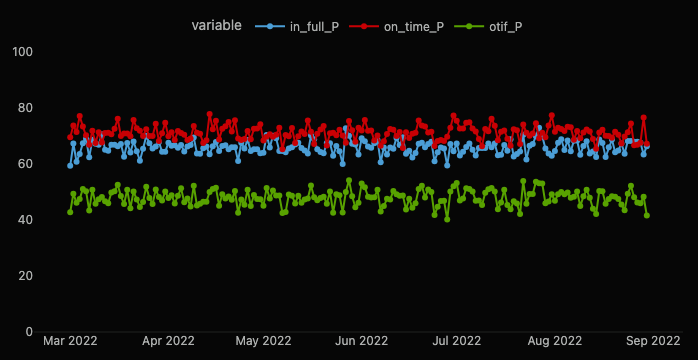

In [554]:
fig1 = px.line(date_level_df, x='order_date', y=['in_full_P', 'on_time_P', 'otif_P'], template='cyborg')

fig1.update_traces(mode="markers+lines", hovertemplate=None)
fig1.update_layout(xaxis_title=None,
    yaxis_title=None,
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    margin=dict(
        #autoexpand=False,
        l=15,
        r=15,
        t=15,
        b=15),
    height=300,
    legend=dict(x=.5, y=1.04, xanchor='center', yanchor='bottom', orientation='h'),
    hovermode="x unified",
    yaxis_range=[0,100]
)

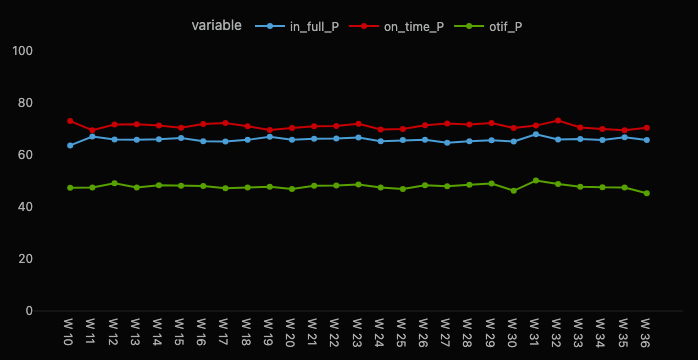

In [555]:
fig2 = px.line(week_df, x='week_no', y=['in_full_P', 'on_time_P', 'otif_P'], template='cyborg',
)

fig2.update_traces(mode="markers+lines", hovertemplate=None)
fig2.update_layout(xaxis_title=None,
    yaxis_title=None,
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    margin=dict(
        #autoexpand=False,
        l=15,
        r=15,
        t=15,
        b=15),
    height=300,
    legend=dict(x=.5, y=1.04, xanchor='center', yanchor='bottom', orientation='h'),
    hovermode="x unified",
    yaxis_range=[0,100]

)

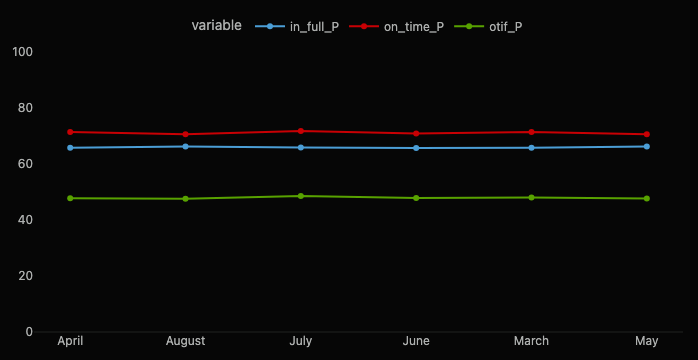

In [556]:
fig3 = px.line(month_df, x='month_name', y=['in_full_P', 'on_time_P', 'otif_P'])

fig3.update_traces(mode="markers+lines", hovertemplate=None)
fig3.update_layout(xaxis_title=None,
    yaxis_title=None,
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    margin=dict(
        #autoexpand=False,
        l=15,
        r=15,
        t=15,
        b=15),
    height=300,
    legend=dict(x=.5, y=1.04, xanchor='center', yanchor='bottom', orientation='h'),
    hovermode="x unified",
    yaxis_range=[0,100]
)

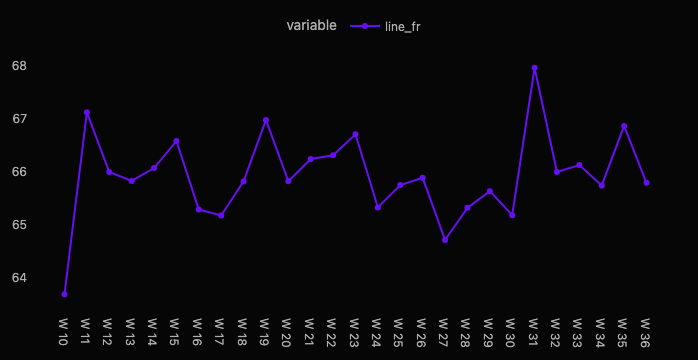

In [557]:
fig18 = px.line(week_df, x='week_no', y=['line_fr'])
fig18.update_traces(mode="markers+lines")
fig18.update_layout(xaxis_title=None,
    yaxis_title=None,
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    margin=dict(
        #autoexpand=False,
        l=15,
        r=15,
        t=15,
        b=15),
    height=300,
    legend=dict(x=.5, y=1.04, xanchor='center', yanchor='bottom', orientation='h'),
    hovermode="x unified"
)
fig18.update_traces(line_color='#6610f2')


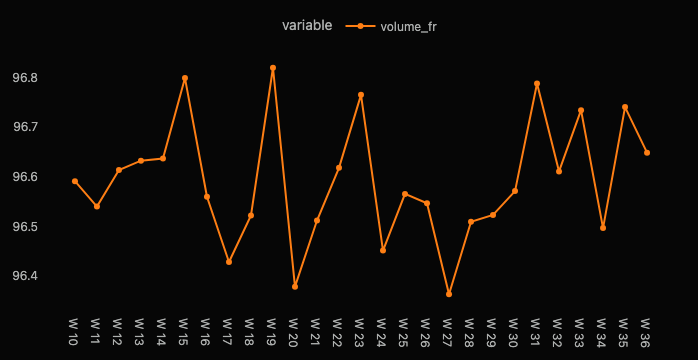

In [558]:
fig19 = px.line(week_df, x='week_no', y=['volume_fr'])
fig19.update_traces(mode="markers+lines")
fig19.update_layout(xaxis_title=None,
    yaxis_title=None,
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    margin=dict(
        #autoexpand=False,
        l=15,
        r=15,
        t=15,
        b=15),
    height=300,
    legend=dict(x=.5, y=1.04, xanchor='center', yanchor='bottom', orientation='h'),
    hovermode="x unified"
)
fig19.update_traces(line_color='#fd7e14')


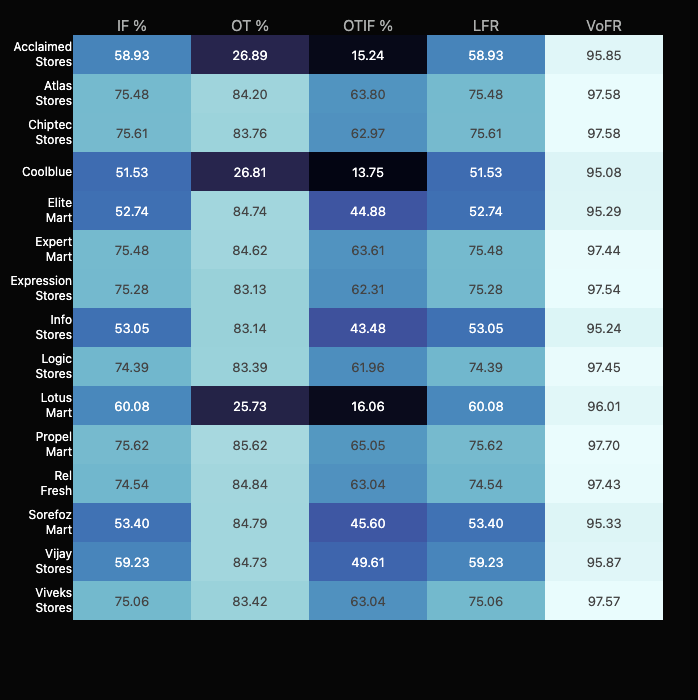

In [564]:
x = customer_level_df[['customer_id', 'in_full_P', 'on_time_P', 'otif_P', 'line_fr', 'volume_fr']].set_index('customer_id')

x_labels=[]
for label in x.index:
    x_labels.append(label.replace(' ','<br>'))
    
fig5 = px.imshow(x, color_continuous_scale='ice', origin='upper', text_auto='.4s', aspect="auto")

fig5.update_traces(textfont=dict(size=13))
fig5.update_layout(coloraxis_showscale=False, margin=dict(l=10,r=35,t=35), xaxis_title=None, yaxis_title=None, height = 700)
fig5.update_xaxes(side='top', tickvals=x.columns, ticktext = ['IF %', 'OT %', 'OTIF %', 'LFR', 'VoFR'], tickfont = dict(size=15))
fig5.update_yaxes(
    tickmode="array",
    tickvals=x.index,
    ticktext=x_labels,
    tickfont=dict(color="white"))


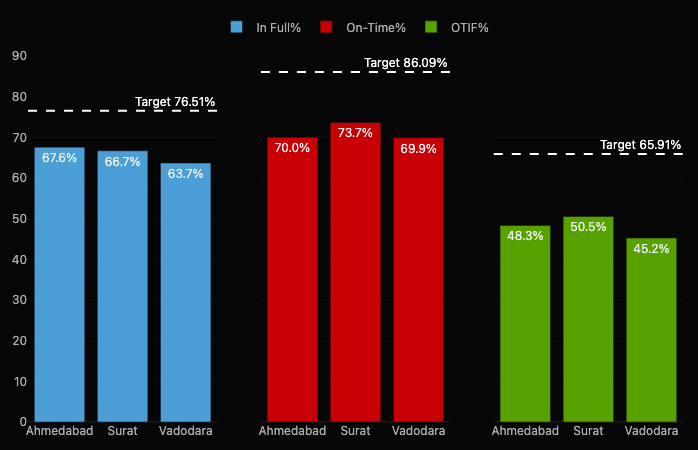

In [565]:
fig15 = make_subplots(rows=1, cols=3, shared_yaxes=True)
fig15.add_trace(
    go.Bar(
        x=city_level_df['city'],      
        y=city_level_df['in_full_P'],
        texttemplate='%{text:.3s}%',
        text=city_level_df['in_full_P'],
        textfont = dict(color = '#EEF0F3'),
        name='In Full%'
    ),row=1, col=1)
fig15.add_trace(
    go.Bar(
        x=city_level_df['city'],      
        y=city_level_df['on_time_P'],        
        texttemplate='%{text:.3s}%',
        text=city_level_df['on_time_P'],
        textfont = dict(color = '#EEF0F3'),
        name='On-Time%'
    ),row=1, col=2)
fig15.add_trace(
    go.Bar(
        x=city_level_df['city'],      
        y=city_level_df['otif_P'],
        texttemplate='%{text:.3s}%',
        text=city_level_df['otif_P'],
        textfont = dict(color = '#EEF0F3'),
        name='OTIF%'
    ),row=1, col=3)
fig15.add_hline(
    y=infull_target, 
    line_width=2, 
    line_dash="dash", 
    line_color="white", 
    row=1, 
    col=1, 
    annotation_text=f'Target {infull_target}%', 
    annotation_font_size=12, 
    annotation_font_color="white")
fig15.add_hline(
    y=ontime_target, 
    line_width=2, 
    line_dash="dash", 
    line_color="white", 
    row=1, 
    col=2, 
    annotation_text=f'Target {ontime_target}%', 
    annotation_font_size=12, 
    annotation_font_color="white")
fig15.add_hline(
    y=otif_target, 
    line_width=2, 
    line_dash="dash", 
    line_color="white", 
    row=1, 
    col=3, 
    annotation_text=f'Target {otif_target}%', 
    annotation_font_size=12, 
    annotation_font_color="white")

fig15.update_layout(margin=dict(l=15,r=15,t=45,b=25), height = 450,legend=dict(x=.5, y=1.04, xanchor='center', yanchor='bottom', orientation='h'))
fig15.update_yaxes(range=[0,90])
#fig15.update_traces(width=.8)

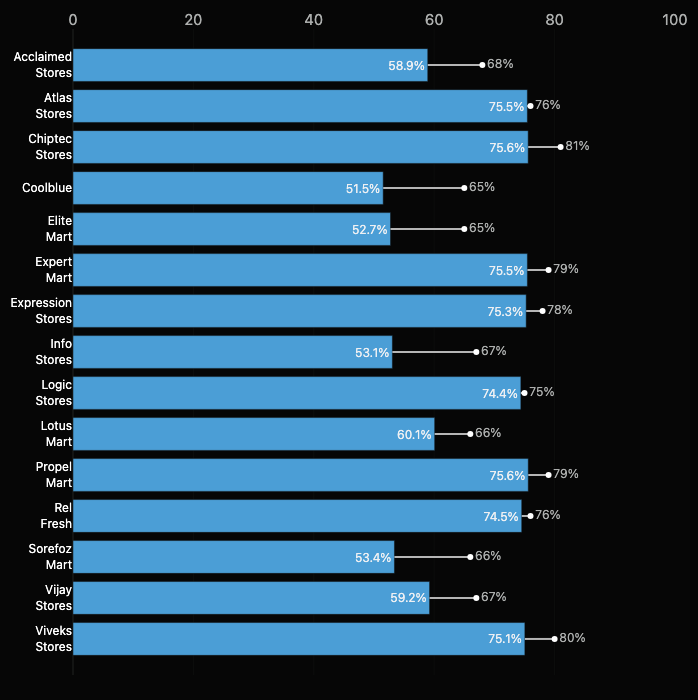

In [587]:

# Plot the bar chart
fig10 = go.Figure(go.Bar(
    y=customer_level_df['customer_id'],
    x=customer_level_df['in_full_P'],
    text=customer_level_df['in_full_P'],
    orientation='h',
    texttemplate='%{text:.3s}%',
    textfont=dict(color='#EEF0F3'),
    marker_color='#4b9ed6')
)

fig10.add_trace(go.Scatter(
    y=customer_level_df['customer_id'],
    x=customer_level_df['infull_target%'],
    mode='markers+text',
    text=customer_level_df['infull_target%'],
    textposition="middle right",
    line=dict(color='white', width=2),
    showlegend=False,
    texttemplate='%{text}%'
))

# Add a scatter trace with lines connecting points to the target percentage
for index, row in customer_level_df.iterrows():
    fig10.add_shape(
        type='line',
        x0=row['infull_target%'],
        x1=row['in_full_P'],
        y0=row['customer_id'],
        y1=row['customer_id'],
        line=dict(color='white', width=2),
        opacity=0.7
    )

fig10.update_layout(xaxis_title=None, margin=dict(l=10, r=15, t=15, b=25), yaxis_title=None, height=700, showlegend=False)
fig10.update_xaxes(side='top', tickfont=dict(size=15), range=[0, 100])
fig10.update_yaxes(
    categoryorder="category descending",
    tickvals=x.index,
    ticktext=x_labels,
    ticklabelposition="outside",
    tickfont=dict(color="white")
)

In [569]:
customer_level_df.columns

Index(['customer_id', 'in_full', 'ifsum', 'ifsize', 'order_count', 'on_time',
       'otif', 'order_qty_sum', 'delivery_qty_sum', 'ontime_target%',
       'infull_target%', 'otif_target%', 'in_full_P', 'on_time_P', 'otif_P',
       'line_fr', 'volume_fr', 'delayed', 'delayed%'],
      dtype='object')

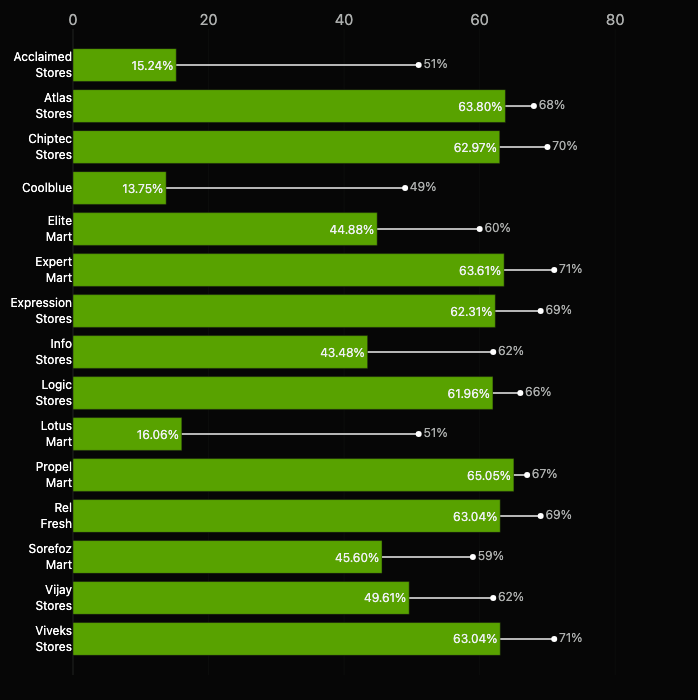

In [581]:
fig11 = go.Figure(
    go.Bar(
    y = trip1['customer_id'],
    x = trip1['otif_P'],
    text = trip1['otif_P'],
    orientation = 'h',
    texttemplate='%{text:.4s}%',
    textfont=dict(color = '#EEF0F3'),
    marker_color = '#58a200')
    )

fig11.add_trace(go.Scatter(
    y=customer_level_df['customer_id'],
    x=customer_level_df['otif_target%'],
    mode='markers+text',
    text=customer_level_df['otif_target%'],
    textposition="middle right",
    line=dict(color='white', width=2),
    showlegend=False,
    texttemplate='%{text}%'
))

# Add a scatter trace with lines connecting points to the target percentage
for index, row in customer_level_df.iterrows():
    fig11.add_shape(
        type='line',
        x0=row['otif_target%'],
        x1=row['otif_P'],
        y0=row['customer_id'],
        y1=row['customer_id'],
        line=dict(color='white', width=2),
        opacity=0.7
    )

fig11.update_layout(xaxis_title=None, margin=dict(l=10, r=15, t=15, b=25), yaxis_title=None, height=700, showlegend=False)
fig11.update_xaxes(side='top', tickfont=dict(size=15), range=[0, 100])
fig11.update_yaxes(
    categoryorder="category descending",
    tickvals=x.index,
    ticktext=x_labels,
    ticklabelposition="outside",
    tickfont=dict(color="white")
)


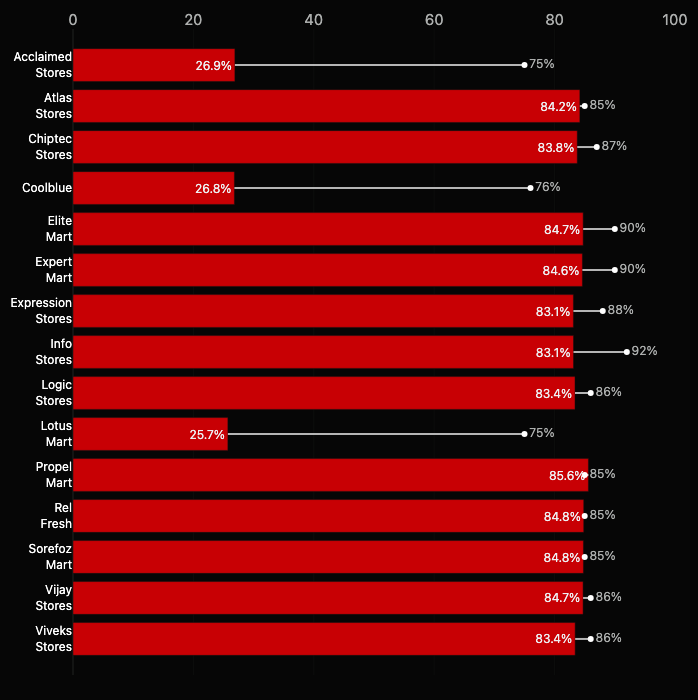

In [586]:
fig12 = go.Figure(
    go.Bar(
    y = trip1['customer_id'],
    x = trip1['on_time_P'],
    text = trip1['on_time_P'],
    orientation = 'h',
    texttemplate='%{text:.3s}%',
    textfont=dict(color = '#EEF0F3'),
    marker_color = '#c80004')
    )

fig12.add_trace(go.Scatter(
    y=customer_level_df['customer_id'],
    x=customer_level_df['ontime_target%'],
    mode='markers+text',
    text=customer_level_df['ontime_target%'],
    textposition="middle right",
    line=dict(color='white', width=2),
    showlegend=False,
    texttemplate='%{text}%'
))

# Add a scatter trace with lines connecting points to the target percentage
for index, row in customer_level_df.iterrows():
    fig12.add_shape(
        type='line',
        x0=row['ontime_target%'],
        x1=row['on_time_P'],
        y0=row['customer_id'],
        y1=row['customer_id'],
        line=dict(color='white', width=2),
        opacity=0.7
    )
    
fig12.update_layout(xaxis_title=None, margin=dict(l=10, r=15, t=15, b=25), yaxis_title=None, height=700, showlegend=False)
fig12.update_xaxes(side='top', tickfont=dict(size=15), range=[0, 100])
fig12.update_yaxes(
    categoryorder="category descending",
    tickvals=x.index,
    ticktext=x_labels,
    ticklabelposition="outside",
    tickfont=dict(color="white")
)

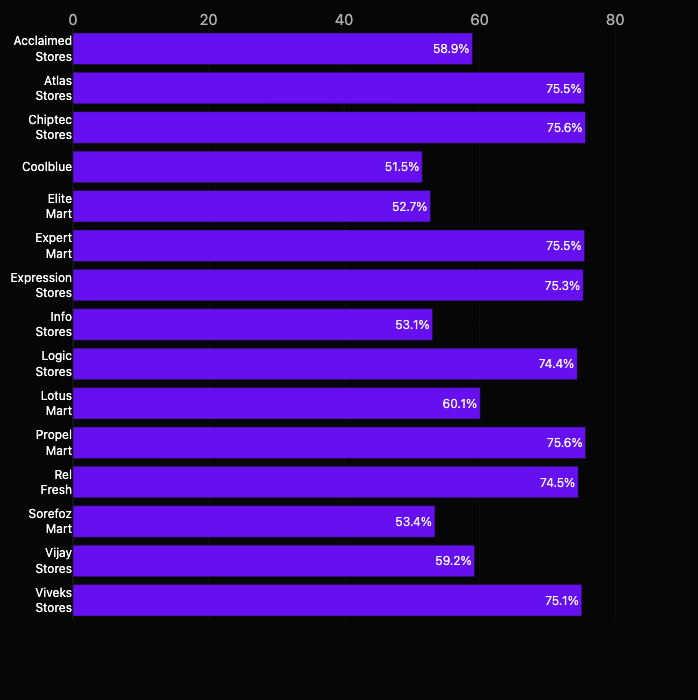

In [588]:
fig17 = go.Figure(
    go.Bar(
    y = trip1['customer_id'],
    x = trip1['line_fr'],
    text = trip1['line_fr'],
    orientation = 'h',
    texttemplate='%{text:.3s}%',
    textfont=dict(color = '#EEF0F3'),
    marker_color = '#6610f2')
    )

fig17.update_layout(xaxis_title=None, margin=dict(l=10,r=15,t=15), yaxis_title=None, height = 700)
fig17.update_xaxes(side='top', tickfont = dict(size=15), range=[0,90])
fig17.update_yaxes(
    categoryorder="category descending",
    tickmode="array",
    tickvals=x.index,
    ticktext=x_labels,
    ticklabelposition="outside",
    tickfont=dict(color="white"))

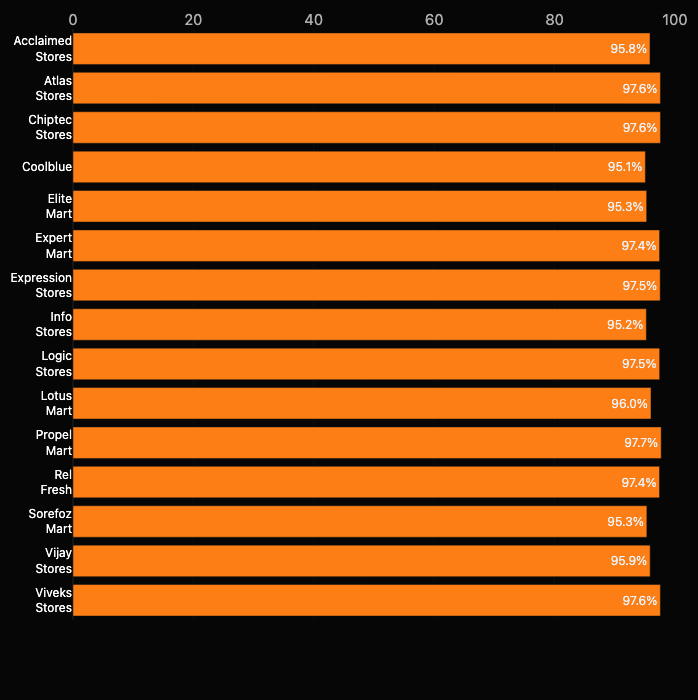

In [589]:
fig18 = go.Figure(
    go.Bar(
    y = trip1['customer_id'],
    x = trip1['volume_fr'],
    text = trip1['volume_fr'],
    orientation = 'h',
    texttemplate='%{text:.3s}%',
    textfont=dict(color = '#EEF0F3'),
    marker_color = '#fd7e14')
    )

fig18.update_layout(xaxis_title=None, margin=dict(l=10,r=15,t=15), yaxis_title=None, height = 700)
fig18.update_xaxes(side='top', tickfont = dict(size=15), range=[0,100])
fig18.update_yaxes(
    categoryorder="category descending",
    tickmode="array",
    tickvals=x.index,
    ticktext=x_labels,
    ticklabelposition="outside",
    tickfont=dict(color="white"))

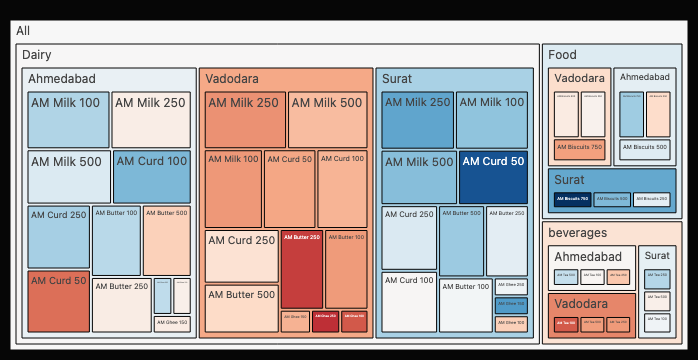

In [590]:

fig16 = px.treemap(
    category_level_df, 
    path=[px.Constant('All'),'category','city', 'product_name'], 
    values='delivery_qty_sum', 
    color='otif',
    color_continuous_scale='RdBu',
    color_continuous_midpoint=np.average(category_level_df['otif'], weights=category_level_df['delivery_qty_sum'])
)
fig16.update_layout(margin = dict(t=20, l=10, r=10, b=10),coloraxis_showscale=False)




In [591]:
dbc_css = "https://cdn.jsdelivr.net/gh/AnnMarieW/dash-bootstrap-templates/dbc.min.css"

app = dash.Dash(external_stylesheets=[dbc.themes.CYBORG, dbc.icons.FONT_AWESOME, dbc_css])

load_figure_template('cyborg')

change_color_ot = 'green' if delta_ot >= 0 else 'red'
change_color_if = 'green' if delta_if >= 0 else 'red'
change_color_otif = 'green' if delta_otif >= 0 else 'red'

arrow_icon_ot = html.I(className="fas fa-arrow-up" if delta_ot >= 0 else "fas fa-arrow-down",
                       style={'color': change_color_ot, 'margin-left': '5px'})
arrow_icon_if = html.I(className="fas fa-arrow-up" if delta_if >= 0 else "fas fa-arrow-down",
                       style={'color': change_color_if, 'margin-left': '5px'})
arrow_icon_otif = html.I(className="fas fa-arrow-up" if delta_otif >= 0 else "fas fa-arrow-down",
                         style={'color': change_color_otif, 'margin-left': '5px'})


sidebar = html.Div([
            html.Br(),
        dbc.Row([
            dbc.Col([
            dbc.Card(
                dbc.CardBody([
                    html.H6("On-Time", style={'textAlign': 'Center','backgroundColor': '#E3E4E8', 'color': 'black'}),
                    html.H6(f'{round(on_time_total,2)}%', style={'textAlign': 'center','display': 'inline'}),
                    arrow_icon_ot,
                    html.P(f" {abs(delta_ot):.2f}% ", style={'font-size': 'smaller', 'color': change_color_ot, 'display': 'inline'}),
                ], style={'textAlign': 'center','padding-left': '0px', 'padding-right': '0px'}
                )
            )
            ]),
            dbc.Col([
            dbc.Card(
                dbc.CardBody([
                    html.H6("In-Full", style={'textAlign': 'Center', 'backgroundColor': '#E3E4E8', 'color': 'black'}),
                    html.H6(f'{round(in_full_total,2)}%', style={'textAlign': 'center','display': 'inline'}),
                    arrow_icon_if,
                    html.P(f" {abs(delta_if):.2f}% ", style={'font-size': 'smaller', 'color': change_color_if, 'display': 'inline'})
                ], style={'textAlign': 'center','padding-left': '0px', 'padding-right': '0px'}
                )
            )
            ]),
            dbc.Col([
            dbc.Card(
                dbc.CardBody([
                    html.H6("OTIF", style={'textAlign': 'Center', 'backgroundColor': '#E3E4E8', 'color': 'black'}),
                    html.H6(f'{round(otif_total,2)}%', style={'textAlign': 'center','display': 'inline'}),                                
                    arrow_icon_otif,
                    html.P(f" {abs(delta_otif):.2f}% ", style={'font-size': 'smaller', 'color': change_color_otif, 'display': 'inline'})
                ], style={'textAlign': 'center','padding-left': '0px', 'padding-right': '0px'}
                )
            )
            ]),
        ]),
            html.Hr(),
        dbc.Row([
            dbc.Col([
            dbc.Card(
                dbc.CardBody([
                    html.H6("Line Fill Rate", style={'textAlign': 'Center', 'backgroundColor': '#E3E4E8', 'color': 'black'}),
                    html.H6(f"{round(line_fr_total, 2):.2f}%")
                ], style={'textAlign': 'center'}
                )
            ),
            ]),
            dbc.Col([
            dbc.Card(
                dbc.CardBody([
                    html.H6("Volume Fill Rate", style={'textAlign': 'Center', 'backgroundColor': '#E3E4E8', 'color': 'black'}),
                    html.H6(f"{round(volume_fr_total, 2):.2f}%")
                ], style={'textAlign': 'center'}
                )
            )
            ]),
        ]),
            html.Hr(),
        dbc.Row([
            dbc.Tabs([
                dbc.Tab(label="Matrix", tab_id="1", children=[dcc.Graph(figure=fig5)]),
                dbc.Tab(label="In-Full", tab_id="2", children=[dcc.Graph(figure=fig10)]),
                dbc.Tab(label="On-Time", tab_id="3", children=[dcc.Graph(figure=fig12)]),
                dbc.Tab(label="OTIF", tab_id="4", children=[dcc.Graph(figure=fig11)]),
                dbc.Tab(label="LFR", tab_id="5", children=[dcc.Graph(figure=fig17)]),
                dbc.Tab(label="VoFR", tab_id="6", children=[dcc.Graph(figure=fig18)]),
            ], active_tab="1")
        ])
    ])




content = html.Div([
    html.Br(),
        dbc.Row([
            dbc.Col([
                dbc.Tabs([
                    dbc.Tab(label='Key-Metrics', tab_id='km', children=[
                        dbc.Tabs([
                            dbc.Tab(label="Day", tab_id="day", children=[dcc.Graph(figure=fig1)]),
                            dbc.Tab(label="Week", tab_id="week", children=[dcc.Graph(figure=fig2)]),
                            dbc.Tab(label="Month", tab_id="month", children=[dcc.Graph(figure=fig3)])
                                ])
                    ]
                           ),
                    dbc.Tab(label='Fill-Rate', tab_id='fr', children=[
                        dbc.Tabs([
                            dbc.Tab(label='Line-FR', tab_id='lfr', children=[dcc.Graph(figure=fig18)]),
                            dbc.Tab(label='Volume-FR', tab_id='vofr', children=[dcc.Graph(figure=fig19)])
                                ]),
                    ]
                           ),
                        ]),
                    ]),
        ]),
            html.Hr(),
        dbc.Row([
            dbc.Col([
                html.P('City Level Metrics'),
                dcc.Graph(figure=fig15)
                    ],width=6
            ),
            dbc.Col([
                html.P('Category and Product Level Metrics'),
                dcc.Graph(figure=fig16)
                    ],width=6
            )
            ])
])

app.layout = dbc.Container([
        dbc.Row([
            dbc.Col(sidebar, width=3),
            dbc.Col(content, width=9)
            ]),
        ],fluid=True)


if __name__ == "__main__":
    app.run_server(debug=True, port=1235)